In [1]:
!pip install pytorch_metric_learning
from fastai.vision.all import *
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
DP = True if torch.cuda.device_count() > 1 else False

In [6]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers,regularizers
from torchvision import datasets, transforms
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from collections import defaultdict

set_seed(42)
def get_image_files_sample(path):
    files = get_image_files(path)
    label_pattern = r'(.+)_\d+.jpg$'
    label_func = using_attr(RegexLabeller(label_pattern), 'name')
    label_to_files = defaultdict(list)
    for file in files:
        label = label_func(file)
        label_to_files[label].append(file)
    sampled_files = []
    for files in label_to_files.values():
        sampled_files.extend(random.sample(files, min(200, len(files))))
    return sampled_files

pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files_sample, 
                 splitter=RandomSplitter(valid_pct=190/200),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(256),
                 batch_tfms=[*aug_transforms(size=(224,224)), Normalize.from_stats(*imagenet_stats)])
loaders = pets.dataloaders(untar_data(URLs.PETS)/"images", bs=256)

In [7]:
classes = len(loaders.vocab)
classes

37

In [8]:
sampler = samplers.MPerClassSampler(loaders.vocab, m=10, batch_size=240, length_before_new_iter=loaders.train.n)
#Fastai 会自动创建一个新的数据加载器，该数据加载器使用相同的数据集，但使用您传递的修改后的关键字参数。
loaders.train = loaders.train.new(shuffle=False, sampler=sampler)

In [9]:
class CustomModel(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))  # Add this line

    def forward(self, x):
        embeddings = self.get_embedding(x)
        classifications = self.head(embeddings)
        return self.avgpool(embeddings).view(embeddings.size(0), -1), classifications

    def get_embedding(self, x):
        x = self.encoder(x)
        return x

backbone=efficientnet_v2_s(weights="DEFAULT")
encoder = create_body(backbone)
head = create_head(backbone.classifier[-1].in_features, 37, [512, 64], 0.5, bn_final=True)
#apply_init(head, nn.init.kaiming_normal_)

model=torch.nn.DataParallel(CustomModel(encoder, head)) if DP else CustomModel(encoder, head)
def siamese_splitter(model):
    return [params(model.module.encoder), params(model.module.head)] if DP else [params(model.encoder), params(model.head)]

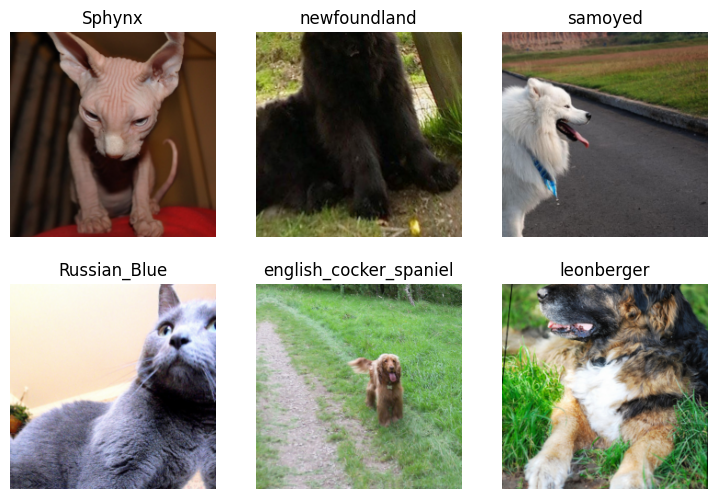

In [10]:
loaders.train.show_batch(max_n=6, nrows=2)

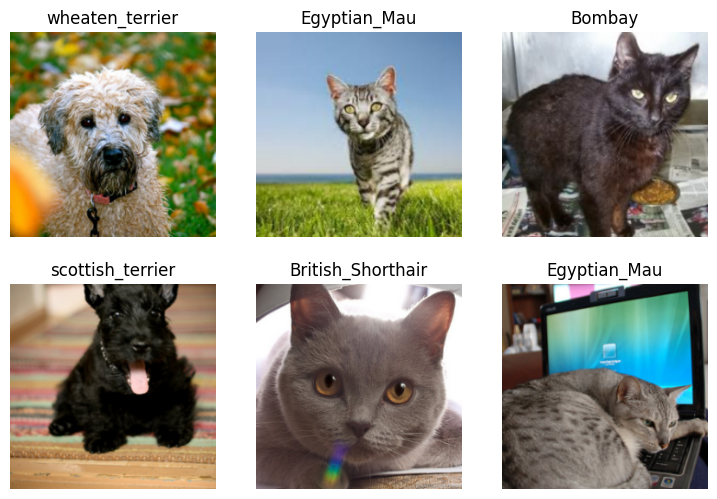

In [11]:
loaders.valid.show_batch(max_n=6, nrows=2)

In [12]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0.1, high=0.9)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")
classification_loss = torch.nn.CrossEntropyLoss()

def mined_loss(miner, loss_func):
    def loss(embeddings, labels):
        mined = miner(embeddings, labels)
        return loss_func(embeddings, labels, mined)
    return loss
  
my_loss = mined_loss(miner = mining_func, loss_func = loss_func)

class CombinedLoss(nn.Module):
    def __init__(self, embed_loss_func, class_loss_func, without_embed=False, without_ce=False):
        super().__init__()
        self.embed_loss_func = embed_loss_func
        self.class_loss_func = class_loss_func
        self.without_embed = without_embed
        self.without_ce = without_ce
    def forward(self, preds, target):
        embeddings, classifications = preds
        embed_loss = self.embed_loss_func(embeddings, target)
        class_loss = self.class_loss_func(classifications, target)
        if self.without_embed:
            return class_loss
        elif self.without_ce:
            return embed_loss
        else:
            return embed_loss + class_loss

combined_loss = CombinedLoss(my_loss, classification_loss)

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[-1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def precision(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return precision_score(targ, pred, average='macro',zero_division=1)

def recall(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return recall_score(targ, pred, average='macro',zero_division=1)

def f1score(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return f1_score(targ, pred, average='macro')

learn=Learner(loaders, 
              model,
              loss_func=combined_loss,
              splitter=siamese_splitter,
              cbs=[ShowGraphCallback, SaveModelCallback(monitor='f1score')],
              metrics=[accuracy,precision,recall,f1score]).to_fp16()

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,4.294991,3.816002,0.017949,0.788211,0.018014,0.005273,00:37
1,4.254338,3.793567,0.016952,0.688631,0.016835,0.005565,00:33
2,4.193910,3.765598,0.025356,0.612431,0.026352,0.010814,00:33
3,4.099769,3.723576,0.050427,0.576208,0.049725,0.029369,00:33
4,3.965437,3.654482,0.111681,0.648901,0.110272,0.088850,00:33
5,3.790294,3.557127,0.196011,0.693272,0.194033,0.168947,00:33
6,3.604823,3.430318,0.318376,0.711396,0.318376,0.299904,00:33
7,3.430819,3.279031,0.440598,0.710575,0.440124,0.411567,00:32
8,3.275845,3.112210,0.532764,0.718134,0.531253,0.494231,00:33
9,3.136399,2.937129,0.601994,0.734898,0.601792,0.570988,00:33


Better model found at epoch 0 with f1score value: 0.005272730057013249.


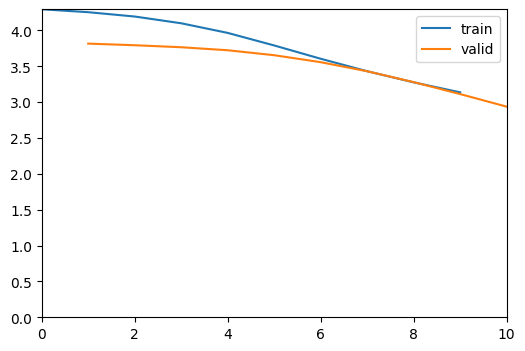

Better model found at epoch 1 with f1score value: 0.005565205761342596.
Better model found at epoch 2 with f1score value: 0.010813705472473897.
Better model found at epoch 3 with f1score value: 0.02936949487853214.
Better model found at epoch 4 with f1score value: 0.08884980593081168.
Better model found at epoch 5 with f1score value: 0.16894745907511974.
Better model found at epoch 6 with f1score value: 0.29990380765020375.
Better model found at epoch 7 with f1score value: 0.4115672528599511.
Better model found at epoch 8 with f1score value: 0.49423123441659395.
Better model found at epoch 9 with f1score value: 0.5709880977318699.


epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,1.756788,2.889532,0.627635,0.743605,0.628861,0.599137,00:34
1,1.812138,2.823834,0.661823,0.750679,0.661828,0.631950,00:33
2,1.808171,2.758201,0.686040,0.759620,0.685715,0.656761,00:32
3,1.802370,2.688265,0.706410,0.760358,0.705333,0.676074,00:28
4,1.774275,2.620144,0.727493,0.771795,0.727481,0.697787,00:28
5,1.769713,2.549667,0.745584,0.780443,0.744675,0.715888,00:28
6,1.752221,2.474652,0.757123,0.783467,0.756325,0.727608,00:28
7,1.736679,2.399906,0.769516,0.797515,0.769362,0.742398,00:28
8,1.711394,2.321020,0.782194,0.805504,0.781560,0.756033,00:28
9,1.686249,2.243367,0.790171,0.813774,0.788164,0.764682,00:27


Better model found at epoch 0 with f1score value: 0.5991373071476837.


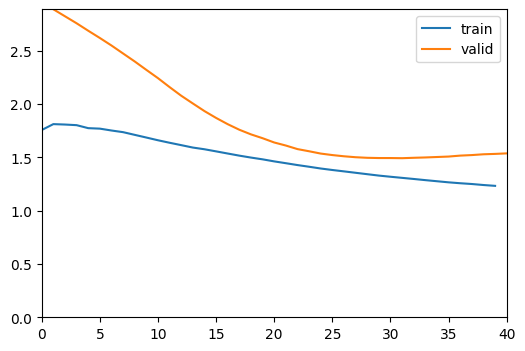

Better model found at epoch 1 with f1score value: 0.6319498119547718.
Better model found at epoch 2 with f1score value: 0.6567613062016292.
Better model found at epoch 3 with f1score value: 0.6760744259233296.
Better model found at epoch 4 with f1score value: 0.697787249581579.
Better model found at epoch 5 with f1score value: 0.7158876134532766.
Better model found at epoch 6 with f1score value: 0.7276083480756343.
Better model found at epoch 7 with f1score value: 0.7423982749293773.
Better model found at epoch 8 with f1score value: 0.7560332717876588.
Better model found at epoch 9 with f1score value: 0.764682456085037.
Better model found at epoch 10 with f1score value: 0.7710469888102336.
Better model found at epoch 11 with f1score value: 0.7817933832684135.
Better model found at epoch 12 with f1score value: 0.789737937473232.
Better model found at epoch 13 with f1score value: 0.7950827734947276.
Better model found at epoch 14 with f1score value: 0.7965706682972749.
Better model found

In [15]:
learn.fine_tune(40,freeze_epochs=10)

In [ ]:
hooks = Hooks(model.module.encoder if DP else model.encoder, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0])
    hooks_output = nn.Flatten()(hooks.stored[-1])
    hooks_output = hooks_output.to(ftrs.device)  # move hooks_output to the same device as ftrs
    ftrs = torch.cat((ftrs, hooks_output))

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

In [ ]:
from umap import UMAP
umap = UMAP(n_components=2)
output = umap.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')